# MARS Test

In [10]:
# from torchreid.utils import FeatureExtractor
# from classes import OSNet
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import display
import cv2

***DOWNLOAD:***

---

# Crop methods:

In [4]:
TEST_IMG = './input/image_2_people.png'
TEST_BBOXS = [[180, 213, 249, 396], [455, 201, 521, 400]]

In [5]:
img = Image.open(TEST_IMG).convert('RGB')
img = img.resize((640, 480))
img_bbox = ImageDraw.Draw(img)

NameError: name 'Image' is not defined

In [6]:
img_bbox.rectangle(TEST_BBOXS[0], outline ='#90EE90')
img_bbox.rectangle(TEST_BBOXS[1], outline = '#87CEEB') 
display(img)

NameError: name 'img_bbox' is not defined

##  Standard crop

In [7]:
crop_img_1 = img.crop(TEST_BBOXS[0])
crop_img_2 = img.crop(TEST_BBOXS[1])

In [8]:
resize_img_1 = crop_img_1.resize((128, 256))
resize_img_2 = crop_img_2.resize((128, 256))

## Mars patch 

In [9]:
def extract_image_patch(image, bbox, patch_shape):
    """Extract image patch from bounding box.
    Parameters
    ----------
    image : ndarray
        The full image.
    bbox : array_like
        The bounding box in format (x, y, width, height).
    patch_shape : Optional[array_like]
        This parameter can be used to enforce a desired patch shape
        (height, width). First, the `bbox` is adapted to the aspect ratio
        of the patch shape, then it is clipped at the image boundaries.
        If None, the shape is computed from :arg:`bbox`.
    Returns
    -------
    ndarray | NoneType
        An image patch showing the :arg:`bbox`, optionally reshaped to
        :arg:`patch_shape`.
        Returns None if the bounding box is empty or fully outside of the image
        boundaries.
    """
    bbox = np.array(bbox)
    if patch_shape is not None:
        # correct aspect ratio to patch shape
        target_aspect = float(patch_shape[1]) / patch_shape[0]
        new_width = target_aspect * bbox[3]
        bbox[0] -= (new_width - bbox[2]) / 2
        bbox[2] = new_width

    # convert to top left, bottom right
    bbox[2:] += bbox[:2]
    bbox = bbox.astype(np.int)

    # clip at image boundaries
    bbox[:2] = np.maximum(0, bbox[:2])
    bbox[2:] = np.minimum(np.asarray(image.shape[:2][::-1]) - 1, bbox[2:])
    if np.any(bbox[:2] >= bbox[2:]):
        return None
    sx, sy, ex, ey = bbox
    image = image[sy:ey, sx:ex]
    image = cv2.resize(image, tuple(patch_shape[::-1]))
    return image

In [10]:
def __preProcess(bboxes):
    #Convert tlrb to tlwh
    boxes = np.array(bboxes)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    return boxes

In [14]:
np_img = np.asarray(img)
bboxs = __preProcess(TEST_BBOXS)

In [15]:
patch_p1 = Image.fromarray(extract_image_patch(np_img, bboxs[0], [256, 128]))
patch_p2 = Image.fromarray(extract_image_patch(np_img, bboxs[1], [256, 128]))

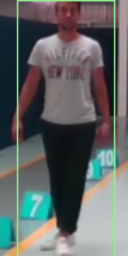

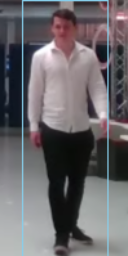

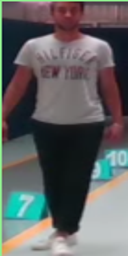

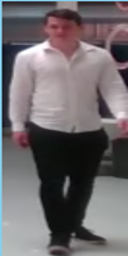

In [16]:
display(patch_p1, patch_p2 )
display(resize_img_1, resize_img_2)

# Compare feature extracton methods:

In [53]:
TEST_IMG = './input/image_2_people.png'
TEST_BBOXS = [[180, 213, 249, 396], [455, 201, 521, 400]]

In [54]:
img = img.crop([180, 213, 249, 396])
img.save('./input/image_2_people_croped.png')

In [6]:
TEST_IMG_CROPED = './input/image_2_people_croped.png'

### (1) Torchreid method:

In [7]:
extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path=TORCH_MODEL,
    device='cuda'
)
features_torch_model = extractor(TEST_IMG_CROPED)

Successfully loaded imagenet pretrained weights from "/home/nvidia/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "./model/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [8]:
features_torch_model = features_torch_model.cpu().detach().numpy()

### (2) My method

In [9]:
# load test image

img = Image.open(TEST_IMG).convert('RGB')
img = img.resize((640, 480))
frame = np.asarray(img, dtype=np.uint8) # input image in format np arrray uint8

In [10]:
os_net = OSNet(model=TRT_FP6_MODEL)
os_net.extractTrackedBBoxFeatures(frame, TEST_BBOX)
features_trt_16 = os_net.tracked_bbox_features

In [11]:
os_net_32 = OSNet(model=TRT_MODEL)
os_net_32.extractTrackedBBoxFeatures(frame, TEST_BBOX)
features_trt = os_net_32.tracked_bbox_features

### Comparison:

<b>Diference - Torchreid vs trt</b>

In [12]:
np.sum(np.abs(features_torch_model - features_trt))

0.0004591601

<b>Diference - Torchreid vs trt FP16:</b>

In [13]:
np.sum(np.abs(features_torch_model - features_trt_16))

1.8127244

### Data prep

In [14]:
import os
import re
import ast
imgs = []

directory = r'./cross_id_imgs_and_bboxes/cross_id_imgs'
for filename in sorted(os.listdir(directory)):
    
    if filename.endswith(".jpg") or filename.endswith(".png"):
        frm = re.findall(r'\d+',filename)
        imgs.append(os.path.join(directory, filename))


In [15]:
TEXT = './cross_id_imgs_and_bboxes/cross_id_bboxes_one_line_culled.txt'

In [16]:
i = 0
person1_bboxes = []
person2_bboxes = []
with open(TEXT) as f:

    for line in f:
        l = line.split(' ', 1)
        frm = l[0]
        if i % 2 == 0:           
            bbox = ast.literal_eval(l[1])
            bbox = [round(x) for x in bbox]
            person1_bboxes.append(bbox)
        else:
            bbox = ast.literal_eval(l[1])
            bbox = [round(x) for x in bbox]
            person2_bboxes.append(bbox)
        i += 1
       

In [17]:
def img2nparray(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((640, 480))
    frame = np.asarray(img, dtype=np.uint8)
    return frame

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.mlab as mlab

In [19]:
plt.rcParams['figure.figsize']= (16,10)

###  Random starting point  / extracting featueres

In [20]:
# random image
import random
start =random.randint(0,len(imgs))
imgs[start]

'./cross_id_imgs_and_bboxes/cross_id_imgs/cross_id_330.png'

In [21]:
osn = OSNet(model=TRT_FP6_MODEL)

In [22]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

159


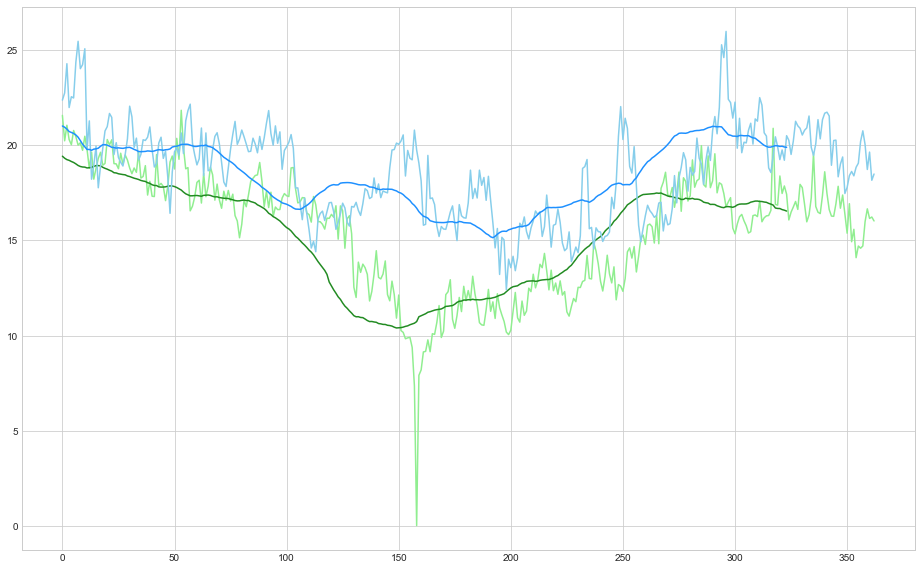

207


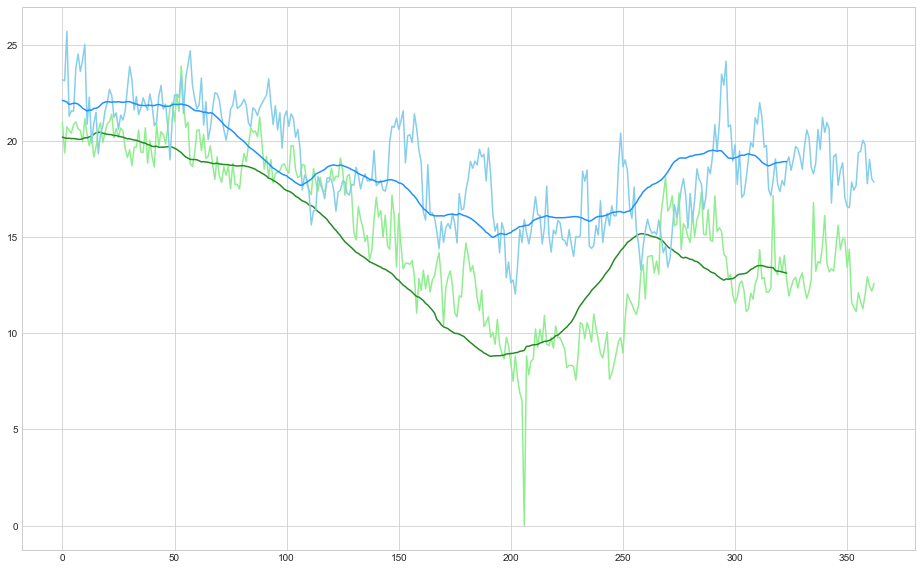

48


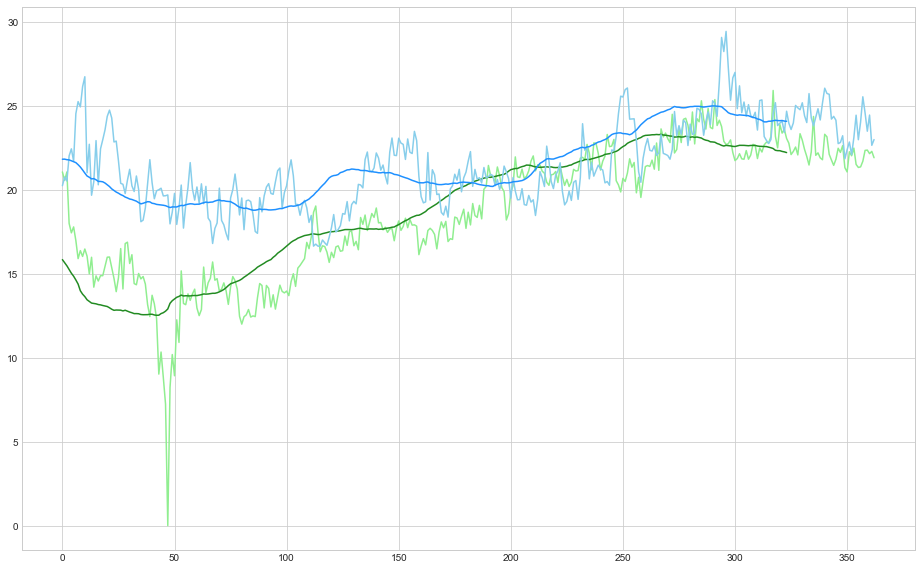

79


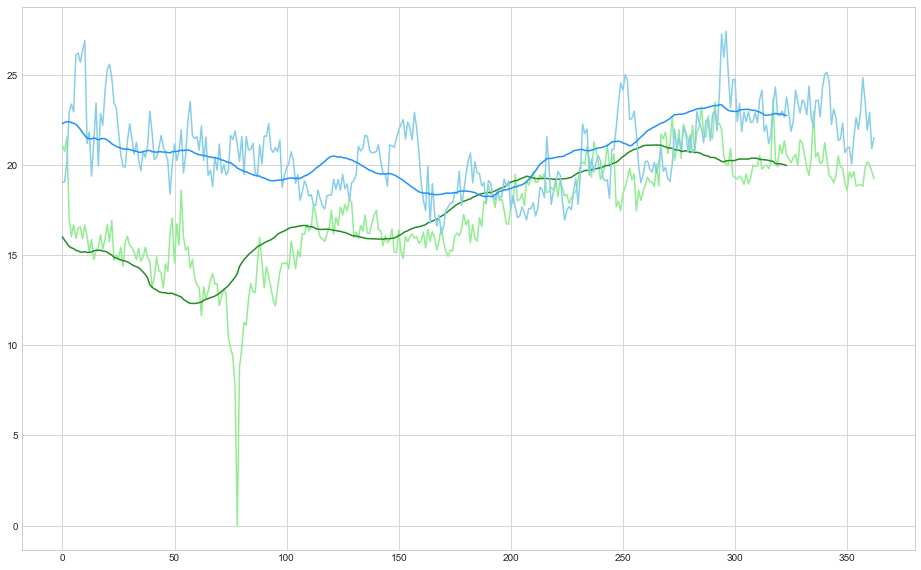

302


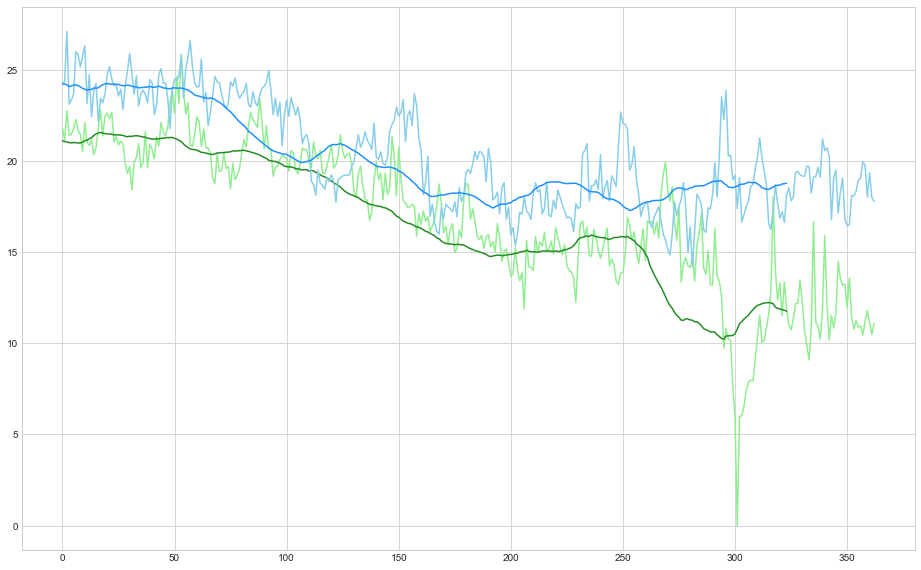

302


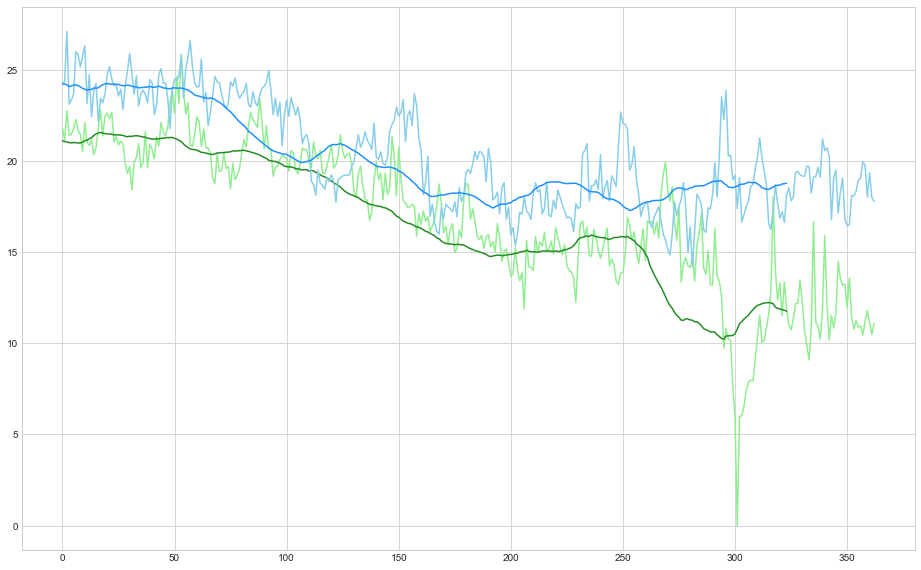

215


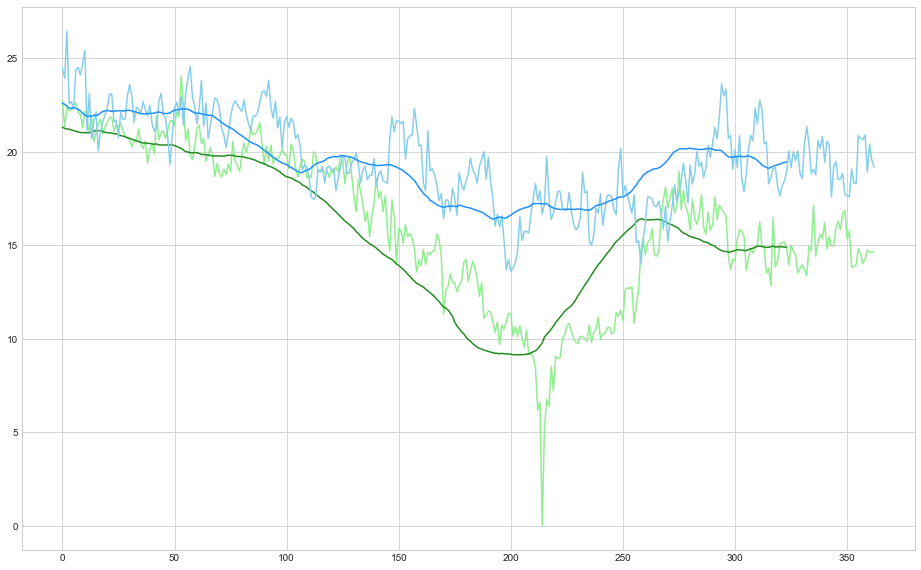

50


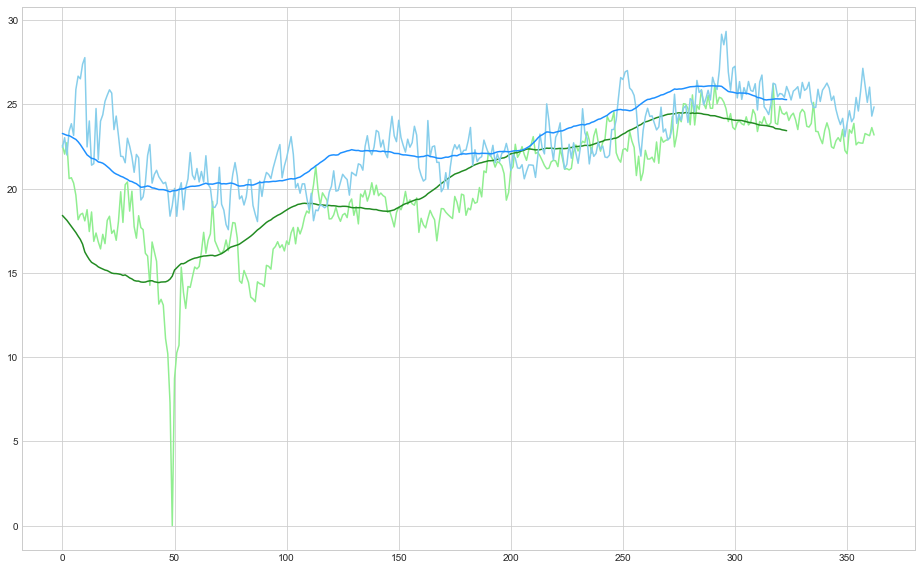

191


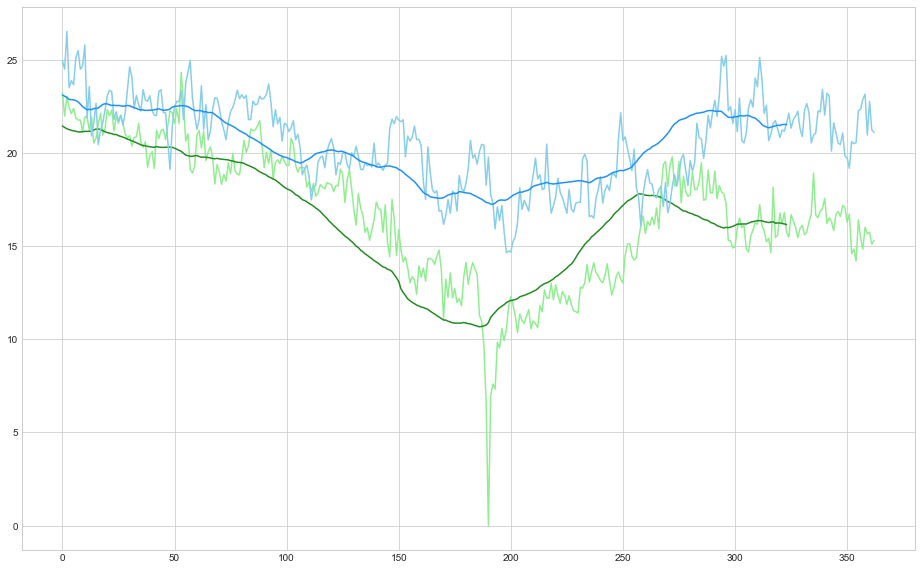

8


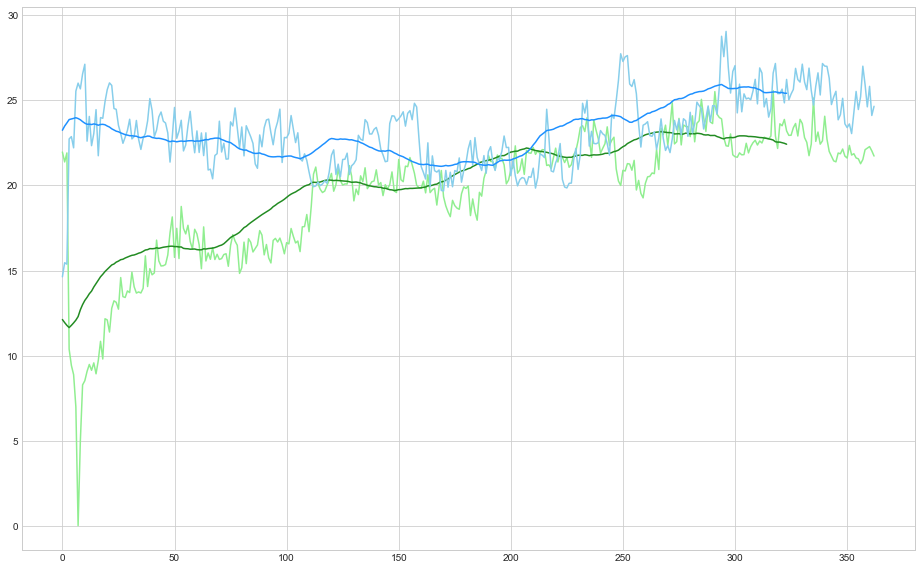

178


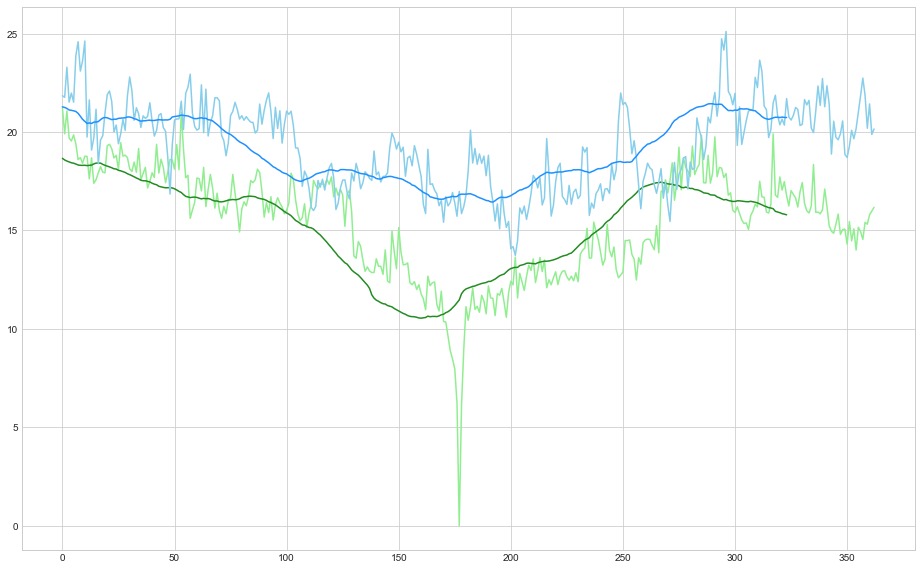

230


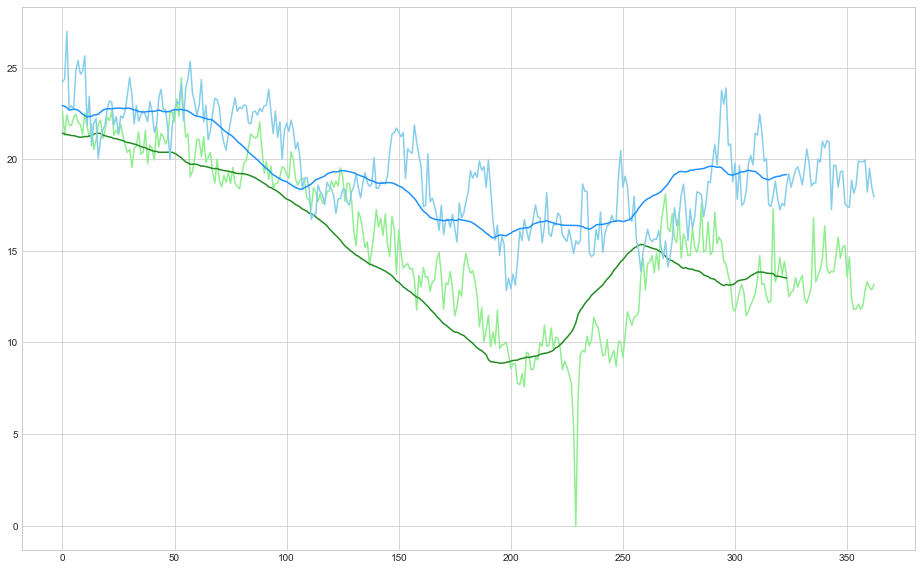

237


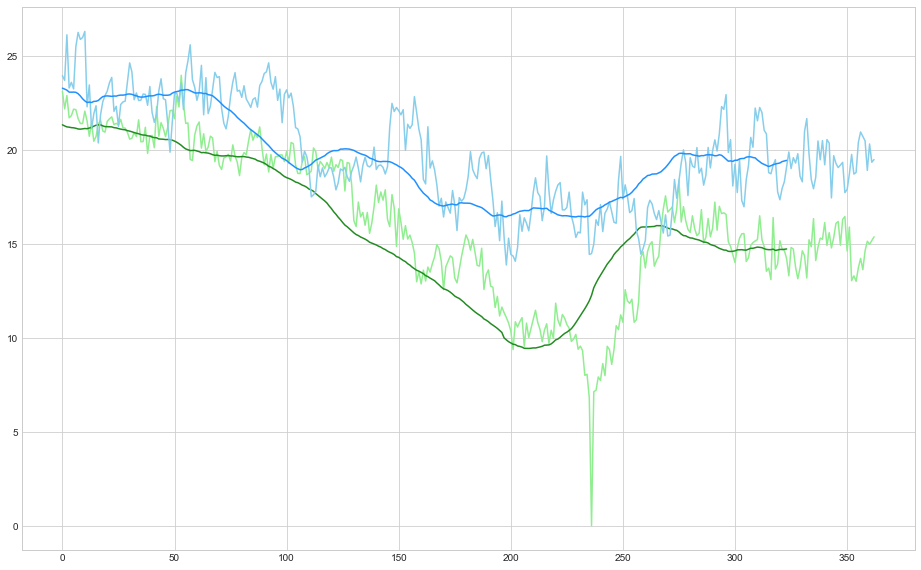

350


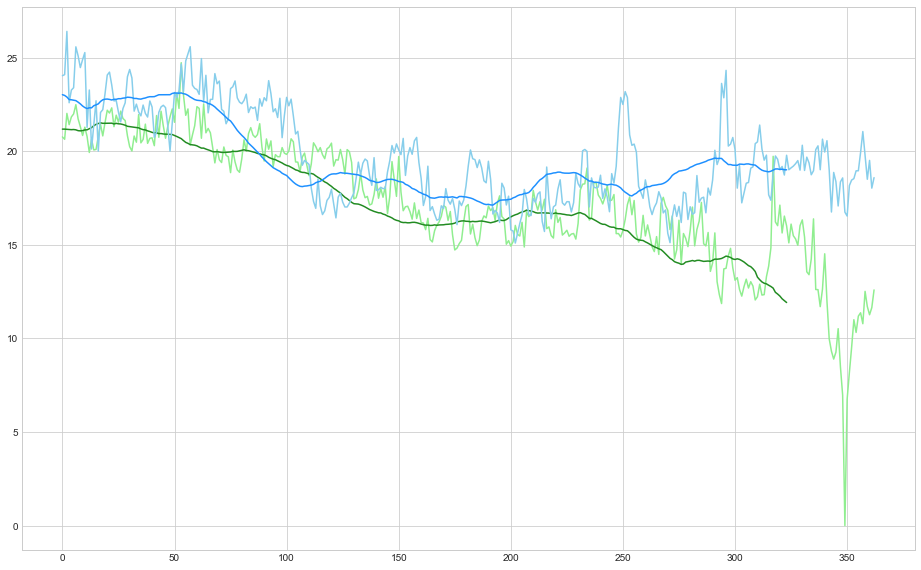

352


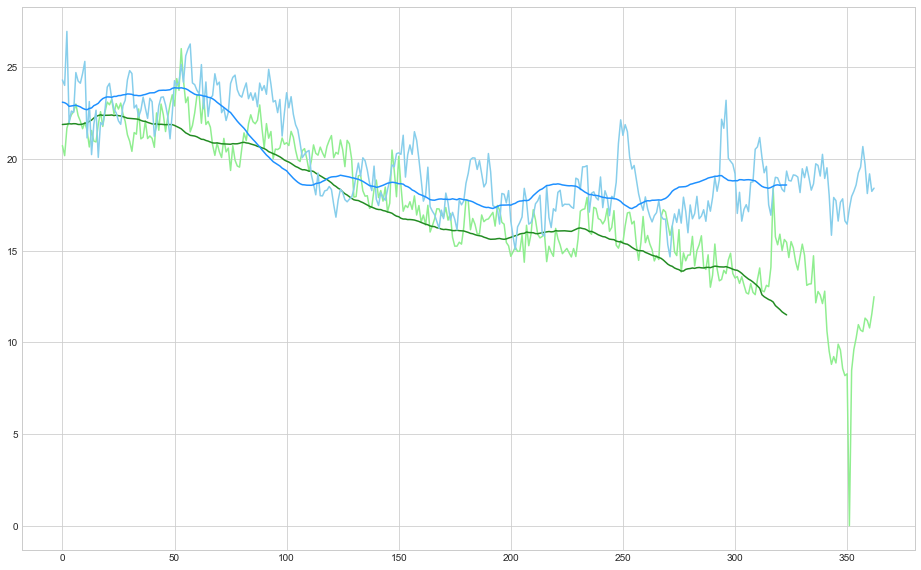

In [23]:
gap_true = []
gap_false = []
for i in range(15):
    start =random.randint(0,len(imgs))
    print(start)
    
    osn.extractTrackedBBoxFeatures(img2nparray(imgs[start]), person1_bboxes[start])
    person1_distances = []
    person2_distances = []
    i = 0
    for img in imgs:
        d1 = osn.calcFeaturesDistance(img2nparray(img), [person1_bboxes[i]])
        d2 = osn.calcFeaturesDistance(img2nparray(img), [person2_bboxes[i]])
        
        if d1 > d2:
            gap_false.append(d1.item(0)-d2.item(0))
        else:
            gap_true.append(d2.item(0)-d1.item(0))
            
               
        person1_distances.append(d1.item(0))
        person2_distances.append(d2.item(0))
        i += 1
    p1_moving_avg = moving_average(person1_distances[1:], 40)
    p2_moving_avg = moving_average(person2_distances[1:], 40)
    plt.plot(person1_distances[1:], 'lightgreen', p1_moving_avg, 'forestgreen', person2_distances[1:], 'skyblue', p2_moving_avg, 'dodgerblue')
    plt.show()
    

Gap

In [ ]:
np.average(gap_true), np.max(gap_true), np.min(gap_true)

In [ ]:
np.average(gap_false), np.max(gap_false), np.min(gap_false)